In [1]:
import pandas as pd

#### Semantic(python method) error counts

In [59]:
def error_counts(df):
    # 1) work on a shallow copy  
    df = df.copy()
    
    # 2) initialize an empty‐list column for every row  
    df['error_category'] = [[] for _ in range(len(df))]
    
    methods = ['merge','groupby','isin','mean','nunique','max','min','idxmax','idxmin']
    
    # 3) only look at the failed rows
    failed_mask = (
    (df['result'] == 'failed:') |
    ((df['result'] != 'failed:') & (df['result'] != 'passed'))
    )
    
    for m in methods:
        # find where the LLM used method 'm' in true_code but not in sample
        mask = (
            failed_mask &
            df['true_code'].str.contains(m, na=False) &
            ~df['sample'].str.contains(m, na=False)
        )
        # append m into the list in error_category
        df.loc[mask, 'error_category'] = (
            df.loc[mask, 'error_category']
              .apply(lambda lst: lst + [m])
        )
    
    return df

In [2]:
# 1. Define your priority list & picker
def semantic_error(df):
    error_df = df.copy()
    priority = ['merge','groupby','mean','isin','min','max','idxmin','idxmax']

    def pick_semantic(cat_list):
        for m in priority:
            if m in cat_list:
                return f"{m}_error"
        return 'task_confusion_error'
    # 2. Initialize the new column to None
    error_df['semantic_error_category'] = None

    # 3. Build a mask for failed rows
    failed_mask = error_df['result'] == 'failed: '

    # 4. Apply only on those rows
    error_df.loc[failed_mask, 'semantic_error_category'] = (
        error_df.loc[failed_mask, 'error_category']
        .apply(pick_semantic)
    )
    return error_df

In [49]:
import textwrap

def add_model_code(df):
    error = df.copy()
    # Prepare the refer code block only once using textwrap.dedent
    refer_code = textwrap.dedent("""
    import pandas as pd

    # Load preprocessed data
    df = pd.read_pickle("preprocessed/main_data.pkl")
    states_df = pd.read_pickle("preprocessed/states_data.pkl")
    ncap_funding_df = pd.read_pickle("preprocessed/ncap_funding_data.pkl")
    print(str(get_response(df, states_df, ncap_funding_df)))
    """)

    # Assign to a new column 'model_code' by vectorized string concatenation
    error["model_code"] = error["sample"] + "\n" + refer_code
    return error

In [65]:
import pandas as pd
import numpy as np
import os
# Load and preprocess
main_data = pd.read_csv("raw_data/main_data.csv")
main_data['Timestamp'] = pd.to_datetime(main_data['Timestamp'])

states_data = pd.read_csv("raw_data/State_data.csv")

ncap_funding_data = pd.read_csv("raw_data/NCAP_Funding.csv")
ncap_funding_data.replace('-', np.nan, inplace=True)
for col in ['Amount released during FY 2019-20', 'Amount released during FY 2020-21',
            'Amount released during FY 2021-22', 'Utilisation as on June 2022']:
    ncap_funding_data[col] = ncap_funding_data[col].astype('float64')

os.makedirs('preprocessed',exist_ok=True)
# Save preprocessed data
main_data.to_pickle("preprocessed/main_data.pkl")
states_data.to_pickle("preprocessed/states_data.pkl")
ncap_funding_data.to_pickle("preprocessed/ncap_funding_data.pkl")

#### syntactic error categorization generated by running model_codes in parallel

In [72]:
import subprocess
import concurrent.futures
import pandas as pd

def execute_code(code: str, timeout: int = 5) -> str:
    """
    Runs a snippet in a subprocess and returns the error type,
    or None if it ran without raising.
    """
    try:
        subprocess.check_output(
            ["python3", "-c", code],
            stderr=subprocess.STDOUT,
            timeout=timeout
        )
        return None
    except subprocess.TimeoutExpired:
        return "TimeoutError"
    except subprocess.CalledProcessError as e:
        # take the last line of the traceback, split off the “Type: message”
        err = e.output.decode("utf-8", errors="ignore").strip().splitlines()[-1]
        return err.split(":")[0]
    except Exception as e:
        return type(e).__name__

def error_type(df: pd.DataFrame) -> pd.DataFrame:
    """
    For rows where (status == False) & (result != "failed: "),
    runs `model_code` in parallel and fills `error_type` with the
    exception type (or None).  All other rows get None.
    """
    df = df.copy()
    # initialize to None everywhere
    df["error_type"] = None

    # mask of rows we actually want to test
    mask = (df["status"] == False) & (df["result"] != "failed: ")

    # extract only the code snippets for those rows
    codes = df.loc[mask, "model_code"].tolist()

    # run in parallel; use ThreadPoolExecutor to avoid pickling hassles
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(execute_code, codes))

    # assign back into the DataFrame
    df.loc[mask, "error_type"] = results

    return df

#### Adding semantic and syntactic categorization in each model's df

In [136]:
df_dict = {}
models = ['Qwen2.5-Coder-1.5B-Instruct','Qwen2.5-Coder-3B-Instruct','Qwen2.5-Coder-7B-Instruct','Qwen2.5-Coder-14B-Instruct']
for model in models:
    common_path = f'/home/vedant.acharya/result/result/unsloth/{model}-bnb-4bit/aggregated_result/result.json'
    df = pd.read_json(common_path)
    df = add_model_code(df)
    df = error_type(df)
    df = error_counts(df)
    df = semantic_error(df)
    df_dict[model] = df

Total distinct categories to plot: 22


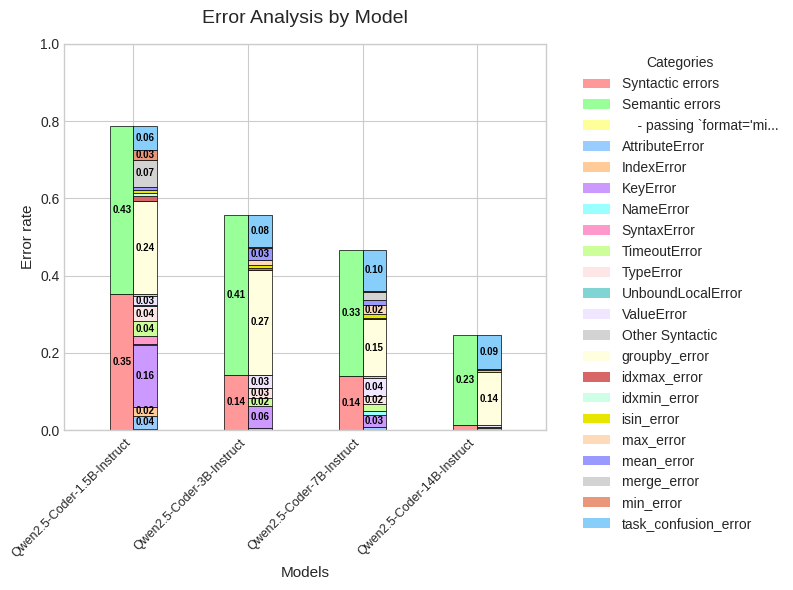

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

# 1) Collect categories
synt_types = set()
sem_types  = set()
for df in df_dict.values():
    if 'result' not in df.columns:
        print(f"Warning: 'result' column not found in one of the dataframes. Skipping.")
        continue
    synt_mask = ~df['result'].astype(str).isin(['failed: ', 'passed'])
    sem_mask  =  df['result'].astype(str) == 'failed: '

    if 'error_type' in df.columns:
        synt_types |= set(df.loc[synt_mask, 'error_type'].dropna().unique())
    # No warning needed here if column missing, handled later

    if 'semantic_error_category' in df.columns:
        sem_types  |= set(df.loc[sem_mask,  'semantic_error_category'].dropna().unique())
    # No warning needed here if column missing, handled later


# 2) Limit categories and add 'Other' if necessary
max_cats_synt = 10 # Reduced max cats to fit 24 total colors better
max_cats_sem = 10 # Reduced max cats
synt_types_sorted = sorted(list(synt_types))
sem_types_sorted = sorted(list(sem_types))

active_synt_types = synt_types_sorted[:max_cats_synt]
active_sem_types = sem_types_sorted[:max_cats_sem]

# Add 'Other' categories if needed
other_synt_needed = len(synt_types_sorted) > max_cats_synt
other_sem_needed = len(sem_types_sorted) > max_cats_sem
if other_synt_needed: active_synt_types.append('Other Syntactic')
if other_sem_needed: active_sem_types.append('Other Semantic')

top_level = ['Syntactic errors', 'Semantic errors']
all_display_cats = top_level + active_synt_types + active_sem_types
num_colors_needed = len(all_display_cats)

print(f"Total distinct categories to plot: {num_colors_needed}")
if num_colors_needed > 24:
     print(f"Warning: Need {num_colors_needed} categories, but only 24 custom colors provided. Categories beyond 24 might share colors or cause errors.")
     # Truncate category list if strictly needed, though ideally adjust max_cats_* earlier
     all_display_cats = all_display_cats[:24]
     num_colors_needed = 24


# 3) Define 24 Custom Light Colors
# (Ensure you have exactly 24 colors defined here)
custom_light_colors = [
    '#ff9999', '#99ff99', '#ffff99', '#99ccff', '#ffcc99', '#cc99ff',
    '#99ffff', '#ff99cc', '#ccff99', '#ffe6e6', '#80d4d4', '#f0e6ff',
    '#c2b280', '#ffffe0', '#d96666', '#ccffe6', '#e6e600', '#ffdab9',
    '#9999ff', '#d3d3d3',
    '#e9967a', '#87cefa', '#ffb6c1', '#cce5ff'  # extra pastels
]



if len(custom_light_colors) < num_colors_needed:
    raise ValueError(f"Need {num_colors_needed} colors, but only {len(custom_light_colors)} custom colors were defined.")

# Create color map using the custom list
color_map = dict(zip(all_display_cats, custom_light_colors[:num_colors_needed]))

# Assign specific colors to 'Other' if they exist, potentially overriding generated ones
if 'Other Syntactic' in color_map: color_map['Other Syntactic'] = '#D3D3D3' # LightGray
if 'Other Semantic' in color_map: color_map['Other Semantic'] = '#A9A9A9' # DarkGray


# 4) Plotting
plt.style.use('seaborn-v0_8-whitegrid')
num_models = len(df_dict)
# Set fixed figure size as requested
fig_w = 8
fig_h = 6
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

bar_w = 0.35 # Keep bar width reasonable
gap   = 1.0  # *** Increased gap significantly ***

label_threshold = 0.02 # Threshold for showing text label inside bar

model_names = list(df_dict.keys())
x_ticks_locs = []
x_ticks_labels = []
all_handles_for_legend = [] # Collect all unique handles for the final legend

for i, (model_name, df) in enumerate(df_dict.items()):
    if 'result' not in df.columns: continue # Skip if no result
    has_synt_col = 'error_type' in df.columns
    has_sem_col = 'semantic_error_category' in df.columns

    x0 = i * (2 * bar_w + gap)
    x1 = x0 + bar_w
    group_center = (x0 + x1) / 2
    x_ticks_locs.append(group_center)
    x_ticks_labels.append(model_name)

    total_qs = len(df)
    if total_qs == 0: continue # Skip if no data

    synt_mask = ~df['result'].astype(str).isin(['failed: ', 'passed']) if has_synt_col else pd.Series([False]*len(df), index=df.index)
    sem_mask  =  df['result'].astype(str) == 'failed: ' if has_sem_col else pd.Series([False]*len(df), index=df.index)

    # === Left Bar: Top-level proportions ===
    num_synt = synt_mask.sum() if has_synt_col else 0
    num_sem = sem_mask.sum() if has_sem_col else 0
    h_synt = num_synt / total_qs
    h_sem  = num_sem / total_qs
    top_vals = {'Syntactic errors': h_synt, 'Semantic errors': h_sem}

    bottom = 0
    for cat, h in top_vals.items():
        if h > 0:
            color = color_map.get(cat, '#808080') # Default black if somehow missing
            ax.bar(x0, h, bottom=bottom, width=bar_w, color=color, edgecolor='black', linewidth=0.5)
            if h > label_threshold:
                 # Choose text color based on background lightness (simple heuristic)
                 text_color = 'black' if np.mean(plt.cm.colors.to_rgb(color)) > 0.5 else 'white'
                 ax.text(x0, bottom + h/2, f"{h:.2f}", ha='center', va='center', fontsize=7, color=text_color, fontweight='bold')
            bottom += h

    # === Right Bar: Error-type breakdown (scaled by overall proportion) ===
    bottom = 0 # Reset bottom for the second bar

    # --- Syntactic Breakdown ---
    synt_total_h = 0
    if has_synt_col:
        synt_counts_abs = df.loc[synt_mask, 'error_type'].value_counts()
        other_synt_count = 0
        processed_cats = set() # Keep track of plotted categories for this bar

        for cat in synt_types_sorted:
            count = synt_counts_abs.get(cat, 0)
            h = count / total_qs

            if cat in active_synt_types and cat != 'Other Syntactic': # Is it one of the top N?
                if h > 0 and cat in color_map:
                    color = color_map[cat]
                    ax.bar(x1, h, bottom=bottom, width=bar_w, color=color, edgecolor='black', linewidth=0.5)
                    if h > label_threshold:
                        text_color = 'black' if np.mean(plt.cm.colors.to_rgb(color)) > 0.5 else 'white'
                        ax.text(x1, bottom + h/2, f"{h:.2f}", ha='center', va='center', fontsize=7, color=text_color, fontweight='bold')
                    bottom += h
                    synt_total_h += h
                    processed_cats.add(cat)
            elif other_synt_needed: # Add to 'Other' count if needed
                other_synt_count += count

        # Add 'Other Syntactic' bar if needed
        if other_synt_needed and other_synt_count > 0:
            h_other = other_synt_count / total_qs
            cat_other = 'Other Syntactic'
            if h_other > 0 and cat_other in color_map:
                color = color_map[cat_other]
                ax.bar(x1, h_other, bottom=bottom, width=bar_w, color=color, edgecolor='black', linewidth=0.5)
                if h_other > label_threshold:
                    text_color = 'black' # Usually black/dark text for black background
                    ax.text(x1, bottom + h_other/2, f"{h_other:.2f}", ha='center', va='center', fontsize=7, color=text_color, fontweight='bold')
                bottom += h_other
                synt_total_h += h_other
                processed_cats.add(cat_other)

    # --- Semantic Breakdown ---
    sem_start_bottom = synt_total_h # Start on top of syntactic
    bottom = sem_start_bottom
    sem_total_h = 0

    if has_sem_col:
        sem_counts_abs = df.loc[sem_mask, 'semantic_error_category'].value_counts()
        other_sem_count = 0
        processed_cats = set() # Keep track for this section too

        for cat in sem_types_sorted:
            count = sem_counts_abs.get(cat, 0)
            h = count / total_qs

            if cat in active_sem_types and cat != 'Other Semantic': # Is it one of the top N?
                 if h > 0 and cat in color_map:
                    color = color_map[cat]
                    ax.bar(x1, h, bottom=bottom, width=bar_w, color=color, edgecolor='black', linewidth=0.5)
                    if h > label_threshold:
                        text_color = 'black' if np.mean(plt.cm.colors.to_rgb(color)) > 0.5 else 'white'
                        ax.text(x1, bottom + h/2, f"{h:.2f}", ha='center', va='center', fontsize=7, color=text_color, fontweight='bold')
                    bottom += h
                    sem_total_h += h
                    processed_cats.add(cat)
            elif other_sem_needed: # Add to 'Other' count if needed
                other_sem_count += count

        # Add 'Other Semantic' bar if needed
        if other_sem_needed and other_sem_count > 0:
            h_other = other_sem_count / total_qs
            cat_other = 'Other Semantic'
            if h_other > 0 and cat_other in color_map:
                color = color_map[cat_other]
                ax.bar(x1, h_other, bottom=bottom, width=bar_w, color=color, edgecolor='black', linewidth=0.5)
                if h_other > label_threshold:
                    text_color = 'black' # Usually black/dark text for black background
                    ax.text(x1, bottom + h_other/2, f"{h_other:.2f}", ha='center', va='center', fontsize=7, color=text_color, fontweight='bold')
                bottom += h_other
                sem_total_h += h_other
                processed_cats.add(cat_other)


# 5) Legend - Placed below the plot
# Create handles only once for all categories that have colors
handles = [Patch(color=color_map[cat], label=cat) for cat in all_display_cats if cat in color_map]

# Place legend below the axes
# Adjust ncol based on how many categories you actually have and figure width
ncol_legend = 5 # Try 5 columns first, adjust as needed
# ax.legend(handles=handles,
#           bbox_to_anchor=(0.5, -0.18), # Position below the plot (adjust y-offset: lower is more negative)
#           loc='upper center',         # Anchor point of the legend box
#           ncol=ncol_legend,           # Arrange in columns
#           fontsize=8,                 # Smaller font for legend
#           title="Error Categories",
#           title_fontsize=9,
#           frameon=True,
#           edgecolor='black')


# 6) Axes formatting
ax.set_ylim(0, 1)
# Adjust xlim based on the increased gap
ax.set_xlim(-bar_w - gap/2, (num_models - 1)*(2 * bar_w + gap) + 2 * bar_w + gap/2) # Add padding using gap
ax.set_ylabel('Error rate', fontsize=11)
ax.set_xlabel('Models', fontsize=11)
ax.set_title('Error Analysis by Model', fontsize=14, pad=15)

# Set x-ticks to be centered under each model group
ax.set_xticks(x_ticks_locs)
# Rotate labels slightly more if names are very long and overlap with large gap
ax.set_xticklabels(x_ticks_labels, rotation=45, ha='right', fontsize=9)
ax.tick_params(axis='x', which='major', pad=5)

# Build legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=color_map[cat], label=(cat[:25] + '...' if len(cat) > 25 else cat))
    for cat in all_display_cats
    if cat in color_map
]

# Then add the legend to your plot with a border
plt.legend(
    handles=legend_elements,
    # frameon=True,
    # edgecolor='black',
    bbox_to_anchor=(1.05, 1),
    title='Categories',  # 👈 Legend title
    title_fontsize='medium'  # Optional: control the title font size
)
# ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)

plt.tight_layout()
plt.show()


# Adjust layout to prevent labels/legend cutoff
# Need more space at the bottom for the legend (increase bottom value)
# Reduce top padding slightly if needed
plt.tight_layout(rect=[0.02, 0.15, 0.98, 0.95]) # [left, bottom, right, top]

plt.show()

# Comparative Error Categorization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import pandas as pd

df = pd.DataFrame(columns=["id", "que_id", "question", "answer", "category", "model", "true_code", "model_answer", "status", "sample", "error category", "error sub-category"])
for i in glob("/content/drive/MyDrive/ML/result/unsloth/*/*_error/result.csv") :
    temp_df = pd.read_csv(i)
    df = pd.concat([df, temp_df])
df


,id,que_id,question,answer,category,model,true_code,model_answer,status,sample,error category,error sub-category
0,317,31,Which station reported the lowest PM2.5 readin...,"Punjabi Bagh, Delhi - DPCC",spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,"32Bungalows, Bhilai - CECB",NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Logical Error,Incorrect Date
1,318,31,Which station reported the lowest PM2.5 readin...,"Punjabi Bagh, Delhi - DPCC",spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,"32Bungalows, Bhilai - CECB",NaN,\nimport pandas as pd\nimport numpy as np\ndef...,Logical Error,Incorrect Date
2,319,31,Which station reported the lowest PM2.5 readin...,"Punjabi Bagh, Delhi - DPCC",spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,"32Bungalows, Bhilai - CECB",NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Logical Error,Incorrect Date
3,370,37,Which city had the most stable PM2.5 levels?,Tirunelveli,spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,Byrnihat,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,var
4,371,37,Which city had the most stable PM2.5 levels?,Tirunelveli,spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,Byrnihat,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,var
...,...,...,...,...,...,...,...,...,...,...,...,...
2,426,42,"In which month (e.g. January, February, ... et...",May,temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: 'int' object has no attribute 'strftime',NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Column Name,NaN
3,427,42,"In which month (e.g. January, February, ... et...",May,temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: list indices must be integers or slice...,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,iloc
4,428,42,"In which month (e.g. January, February, ... et...",May,temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: 'numpy.int32' object has no attribute ...,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,iloc
5,585,58,Which city had the highest PM2.5 levels on Ind...,Chhapra,spatio_temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: attempt to get argmax of an empty sequ...,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,idxmax


In [ ]:
df['error'] = df['model_answer'].apply(lambda x: "Syntactic Error" if str(x).find("failed: ") == -1 else "Semantic Error")
df

,id,que_id,question,answer,category,model,true_code,model_answer,status,sample,error category,error sub-category,error
0,317,31,Which station reported the lowest PM2.5 readin...,"Punjabi Bagh, Delhi - DPCC",spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,"32Bungalows, Bhilai - CECB",NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Logical Error,Incorrect Date,Syntactic Error
1,318,31,Which station reported the lowest PM2.5 readin...,"Punjabi Bagh, Delhi - DPCC",spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,"32Bungalows, Bhilai - CECB",NaN,\nimport pandas as pd\nimport numpy as np\ndef...,Logical Error,Incorrect Date,Syntactic Error
2,319,31,Which station reported the lowest PM2.5 readin...,"Punjabi Bagh, Delhi - DPCC",spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,"32Bungalows, Bhilai - CECB",NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Logical Error,Incorrect Date,Syntactic Error
3,370,37,Which city had the most stable PM2.5 levels?,Tirunelveli,spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,Byrnihat,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,var,Syntactic Error
4,371,37,Which city had the most stable PM2.5 levels?,Tirunelveli,spatial_aggregation,unsloth/Qwen2.5-Coder-1.5B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,Byrnihat,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,var,Syntactic Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,426,42,"In which month (e.g. January, February, ... et...",May,temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: 'int' object has no attribute 'strftime',NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Column Name,NaN,Semantic Error
3,427,42,"In which month (e.g. January, February, ... et...",May,temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: list indices must be integers or slice...,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,iloc,Semantic Error
4,428,42,"In which month (e.g. January, February, ... et...",May,temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: 'numpy.int32' object has no attribute ...,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,iloc,Semantic Error
5,585,58,Which city had the highest PM2.5 levels on Ind...,Chhapra,spatio_temporal_aggregation,unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit,def true_code():\n import pandas as pd\n ...,failed: attempt to get argmax of an empty sequ...,NaN,\nimport pandas as pd\nimport numpy as np\n\nd...,Wrong Method,idxmax,Semantic Error


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, 0 to 6
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  476 non-null    object
 1   que_id              476 non-null    object
 2   question            476 non-null    object
 3   answer              476 non-null    object
 4   category            476 non-null    object
 5   model               476 non-null    object
 6   true_code           476 non-null    object
 7   model_answer        462 non-null    object
 8   status              0 non-null      object
 9   sample              476 non-null    object
 10  error category      476 non-null    object
 11  error sub-category  422 non-null    object
 12  error               476 non-null    object
dtypes: object(13)
memory usage: 68.2+ KB


<ipython-input-5-c13450a90a33>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.index, y=error_counts.values, palette='viridis')


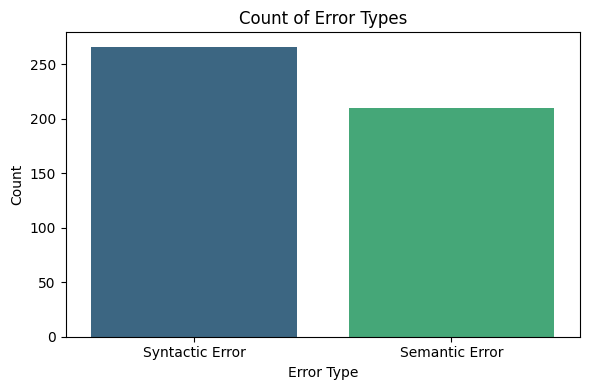

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
error_counts = df['error'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=error_counts.index, y=error_counts.values, palette='viridis')
plt.title('Count of Error Types')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


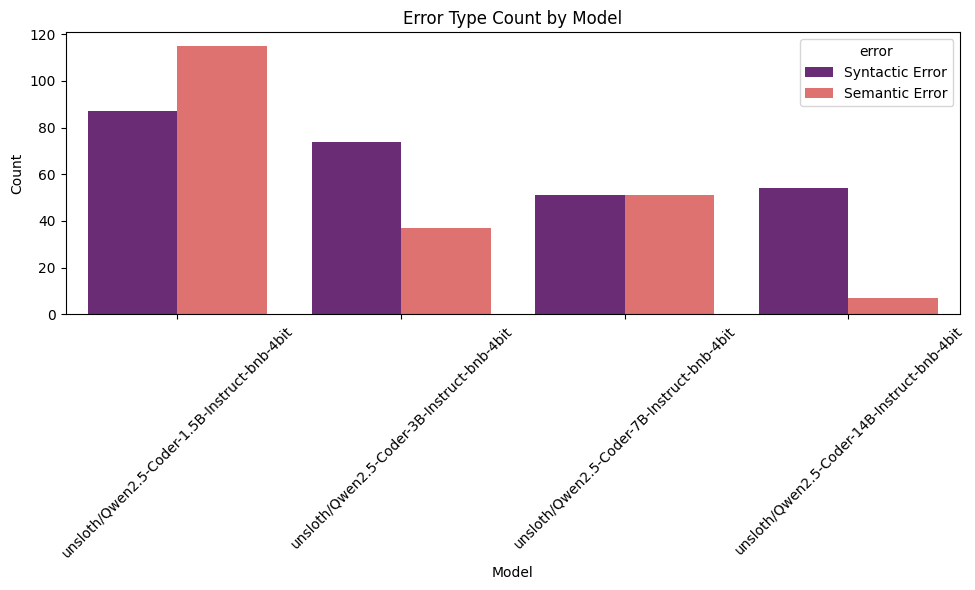

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='model', hue='error', palette='magma')
plt.title('Error Type Count by Model')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


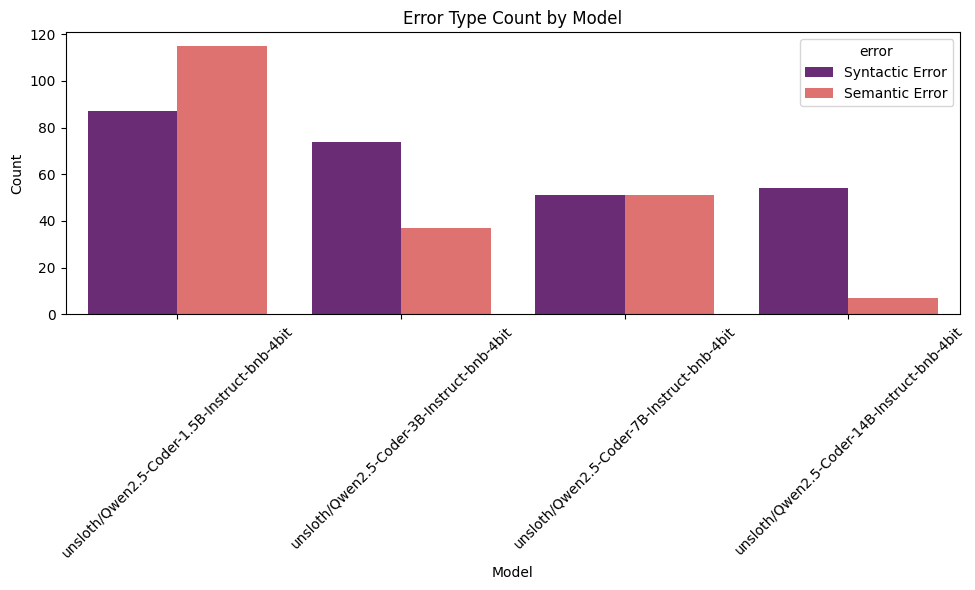

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='model', hue='error', palette='magma')
plt.title('Error Type Count by Model')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


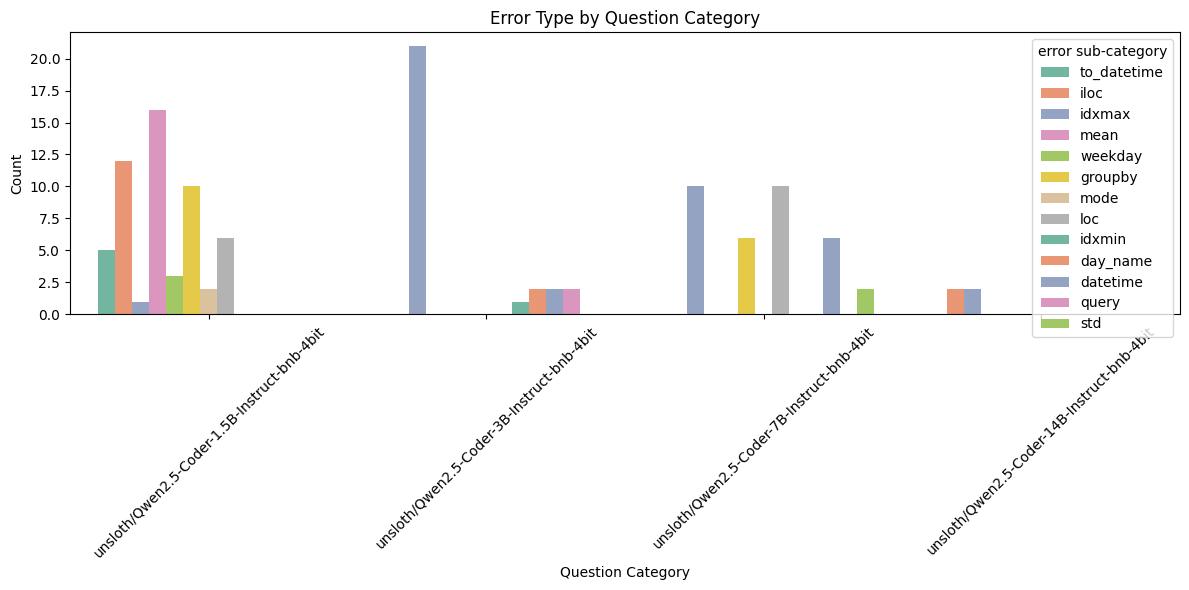

In [ ]:
plt.figure(figsize=(12, 6))
semantic_error_counts = df[(df['error'] == 'Semantic Error') & (df['error category'] == 'Wrong Method')]
sns.countplot(data=semantic_error_counts, x='model', hue='error sub-category', palette='Set2')
plt.title('Error Type by Question Category')
plt.xlabel('Question Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


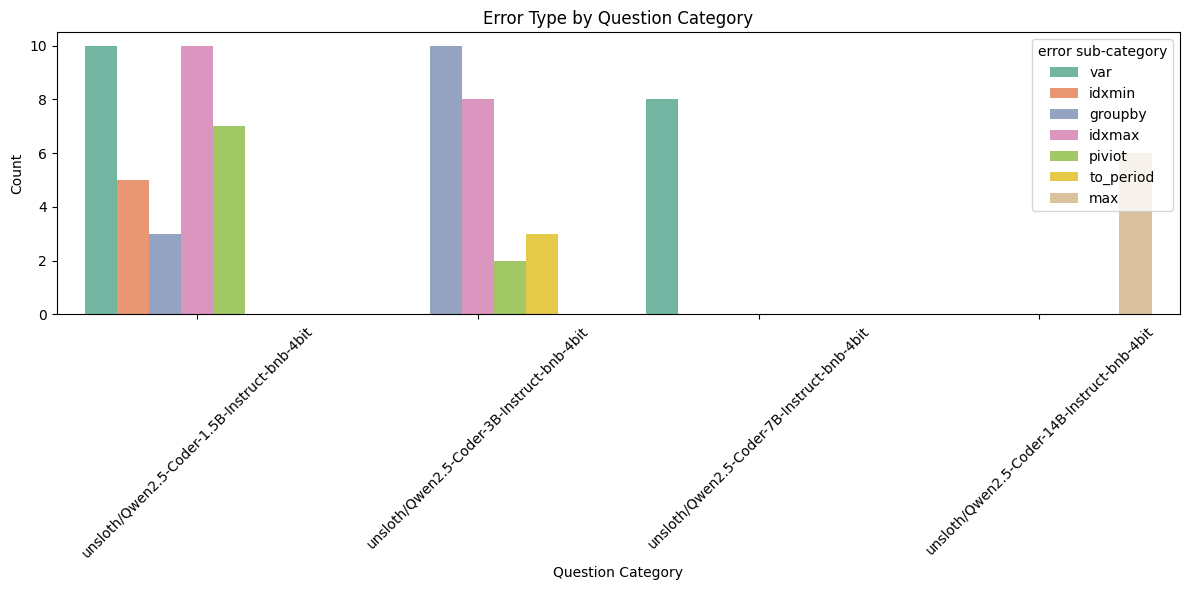

In [ ]:
plt.figure(figsize=(12, 6))
syntactic_error_counts = df[(df['error'] == 'Syntactic Error') & (df['error category'] == 'Wrong Method')]
sns.countplot(data=syntactic_error_counts, x='model', hue='error sub-category', palette='Set2')
plt.title('Error Type by Question Category')
plt.xlabel('Question Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


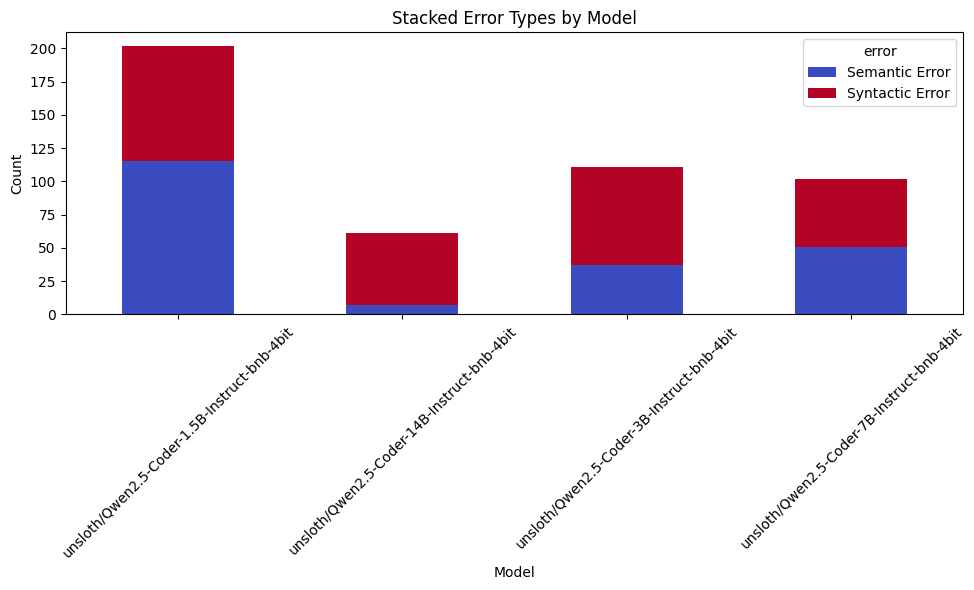

In [ ]:
error_by_model = df.groupby(['model', 'error']).size().unstack().fillna(0)

error_by_model.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Stacked Error Types by Model')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
